# An AI-Powered System for De-identifying Protected Health Information in Clinical Text Using SpaCy NER

## Importing necessary libraries

In [1]:
pip install spacy


In [2]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import random

# NLP libraries
import spacy
from spacy.util import minibatch, compounding
from spacy.training import Example

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_curve, auc, roc_auc_score, 
                             precision_recall_fscore_support)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


# 2. Data Loading

In [4]:
# Load the dataset
medical_data = pd.read_csv('medical_data.csv')

# Display the first few rows
print(medical_data.head())


   Patient_ID  Age  Gender    Medical_Condition         Treatment   Outcome  \
0           1   77  Female  Chronic Obstructive          Dialysis    Stable   
1           2   62  Female              Obesity  Physical therapy  Improved   
2           3   77    Male         Hypertension   Inhaler therapy  Improved   
3           4   41  Female  Alzheimer's Disease      Medication C  Worsened   
4           5   82    Male  Alzheimer's Disease      Chemotherapy    Stable   

  Insurance_Type  Income Region Smoking_Status Admission_Type  Hospital_ID  \
0         Public   77444  North  Former smoker         Urgent         3173   
1         Public   19367   West     Non-smoker         Urgent        65671   
2       Medicare   16054  North     Non-smoker         Urgent        96914   
3       Medicare   54371   West     Non-smoker      Emergency        15732   
4        Private   55489   West     Non-smoker      Emergency        98232   

   Length_of_Stay  
0              20  
1               

In [5]:
# Check for basic information about the dataset (columns, data types, non-null counts)
medical_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         1000 non-null   int64 
 1   Age                1000 non-null   int64 
 2   Gender             1000 non-null   object
 3   Medical_Condition  1000 non-null   object
 4   Treatment          1000 non-null   object
 5   Outcome            1000 non-null   object
 6   Insurance_Type     1000 non-null   object
 7   Income             1000 non-null   int64 
 8   Region             1000 non-null   object
 9   Smoking_Status     1000 non-null   object
 10  Admission_Type     1000 non-null   object
 11  Hospital_ID        1000 non-null   int64 
 12  Length_of_Stay     1000 non-null   int64 
dtypes: int64(5), object(8)
memory usage: 101.7+ KB


In [6]:
# Get descriptive statistics for numerical columns
medical_data.describe()


,Patient_ID,Age,Income,Hospital_ID,Length_of_Stay
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,45.710000,50181.756000,51709.297000,10.041000
std,288.819436,26.797612,29178.022872,29653.627294,6.066145
min,1.000000,0.000000,169.000000,37.000000,0.000000
25%,250.750000,22.750000,24079.750000,25293.000000,5.000000
50%,500.500000,45.000000,51972.500000,52220.500000,10.000000
75%,750.250000,70.000000,74972.500000,78788.000000,15.000000
max,1000.000000,90.000000,99980.000000,99978.000000,20.000000


In [7]:
medical_data.columns

Index(['Patient_ID', 'Age', 'Gender', 'Medical_Condition', 'Treatment',
       'Outcome', 'Insurance_Type', 'Income', 'Region', 'Smoking_Status',
       'Admission_Type', 'Hospital_ID', 'Length_of_Stay'],
      dtype='object')

## Identifying Missing

In [8]:
# Calculate and display the percentage of missing values in each column
missing_data = medical_data.isnull().mean() * 100
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print("Columns with missing values:\n", missing_data)


Columns with missing values:
 Series([], dtype: float64)


## Analyze Column Types and Potential PHI Elements

In [9]:
medical_data.sample(10)

,Patient_ID,Age,Gender,Medical_Condition,Treatment,Outcome,Insurance_Type,Income,Region,Smoking_Status,Admission_Type,Hospital_ID,Length_of_Stay
968,969,25,Female,Anxiety,Bone density tests,Improved,Medicare,11529,South,Former smoker,Emergency,39930,4
96,97,26,Male,Chronic Obstructive,Dialysis,Improved,Public,39653,East,Former smoker,Urgent,77062,2
126,127,15,Male,Osteoporosis,Inhaler therapy,Improved,Medicare,42279,South,Former smoker,Urgent,52187,16
233,234,70,Female,Obesity,Dietary counseling,Improved,Medicare,20512,North,Non-smoker,Emergency,77845,8
162,163,14,Male,Diabetes,Medication C,Stable,Public,19210,North,Non-smoker,Emergency,93325,11
854,855,44,Male,Chronic Kidney Disease,Medication B,Worsened,Private,98278,North,Non-smoker,Emergency,99521,12
698,699,28,Male,Rheumatoid Arthritis,Chemotherapy,Worsened,Medicare,3671,West,Non-smoker,Emergency,60248,13
92,93,14,Female,Cancer,Dietary counseling,Improved,Medicare,6150,North,Non-smoker,Elective,8685,0
955,956,30,Male,Hypertension,Bone density tests,Worsened,Medicare,65695,South,Non-smoker,Emergency,52633,19
462,463,90,Male,Stroke,Immunosuppressants,Worsened,Private,24134,North,Non-smoker,Urgent,39908,2


In [10]:
# Count unique values in categorical columns to understand the variety
for column in medical_data.select_dtypes(include=['object']).columns:
    print(f"Column: {column}")
    print(medical_data[column].value_counts().head())
    print("\n")

Column: Gender
Gender
Male          462
Female        442
Polygender     20
Non-binary     19
Bigender       18
Name: count, dtype: int64


Column: Medical_Condition
Medical_Condition
Chronic Kidney Disease    81
Chronic Obstructive       79
Rheumatoid Arthritis      77
Depression                77
Diabetes                  76
Name: count, dtype: int64


Column: Treatment
Treatment
Medication B          93
Therapy               85
Physical therapy      82
Immunosuppressants    80
Dietary counseling    77
Name: count, dtype: int64


Column: Outcome
Outcome
Improved    363
Worsened    324
Stable      313
Name: count, dtype: int64


Column: Insurance_Type
Insurance_Type
Private     340
Public      330
Medicare    330
Name: count, dtype: int64


Column: Region
Region
South    263
North    255
West     247
East     235
Name: count, dtype: int64


Column: Smoking_Status
Smoking_Status
Former smoker    500
Non-smoker       500
Name: count, dtype: int64


Column: Admission_Type
Admission_Type


# 3. Exploratory Data Analysis (EDA)

##  Understanding the Data

In [11]:
# Get basic information about the dataset
print(medical_data.info())

# Check for missing values
print(medical_data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         1000 non-null   int64 
 1   Age                1000 non-null   int64 
 2   Gender             1000 non-null   object
 3   Medical_Condition  1000 non-null   object
 4   Treatment          1000 non-null   object
 5   Outcome            1000 non-null   object
 6   Insurance_Type     1000 non-null   object
 7   Income             1000 non-null   int64 
 8   Region             1000 non-null   object
 9   Smoking_Status     1000 non-null   object
 10  Admission_Type     1000 non-null   object
 11  Hospital_ID        1000 non-null   int64 
 12  Length_of_Stay     1000 non-null   int64 
dtypes: int64(5), object(8)
memory usage: 101.7+ KB
None
Patient_ID           0
Age                  0
Gender               0
Medical_Condition    0
Treatment            0
Outcome          

## Correlation Heatmap

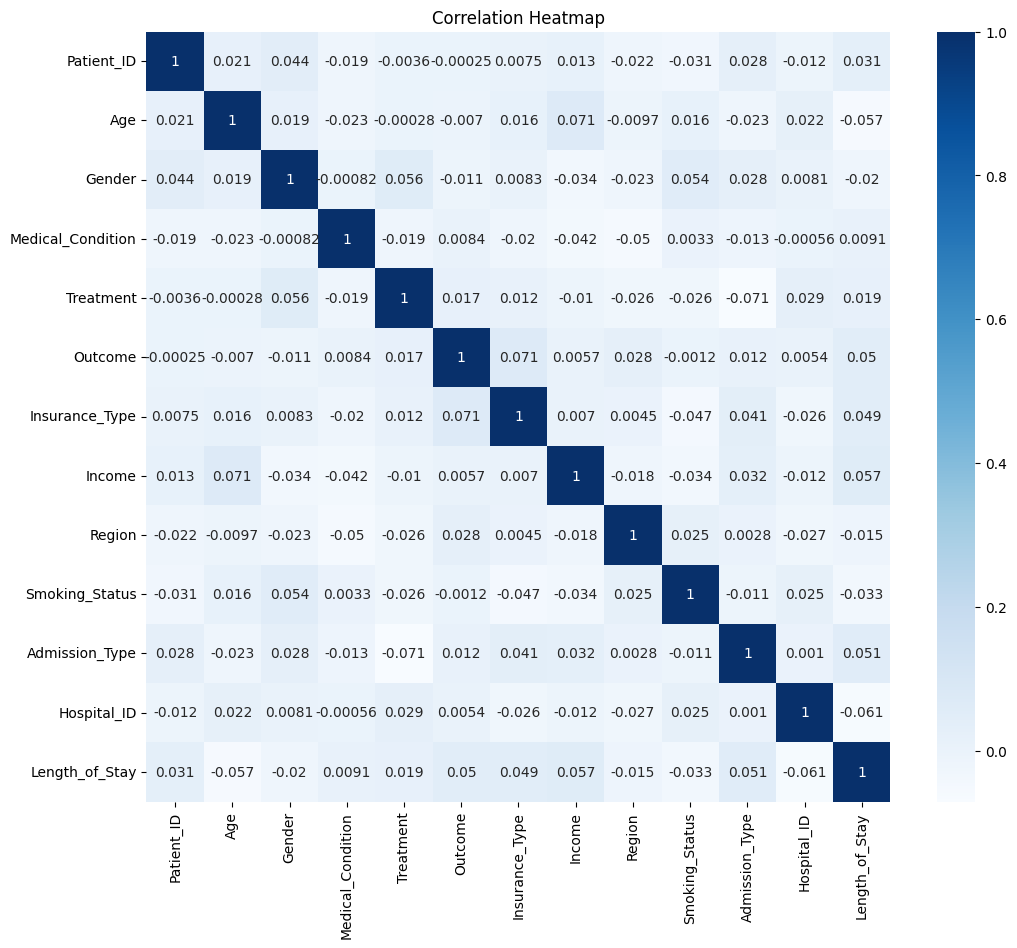

In [12]:
encoded_data = medical_data.copy()

# Identify categorical columns
categorical_cols = ['Gender', 'Medical_Condition', 'Treatment', 'Outcome', 'Insurance_Type', 'Region', 'Smoking_Status', 'Admission_Type', 'Hospital_ID']

# Encode categorical variables
for column in categorical_cols:
    encoded_data[column] = encoded_data[column].astype('category').cat.codes

# Compute the correlation matrix
corr_matrix = encoded_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()


## Plotting the Age Distribution Histogram

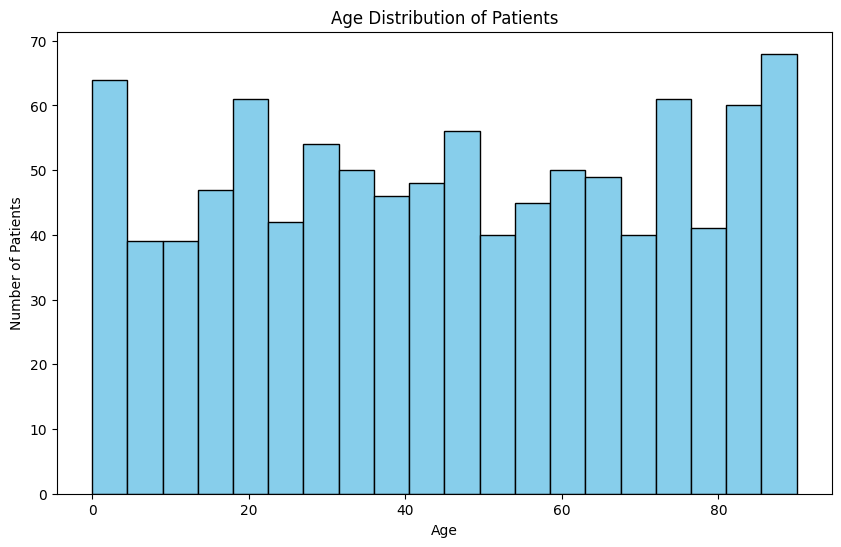

In [13]:
# Plot the age distribution
plt.figure(figsize=(10, 6))
plt.hist(medical_data['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.show()


## Visualizing Gender

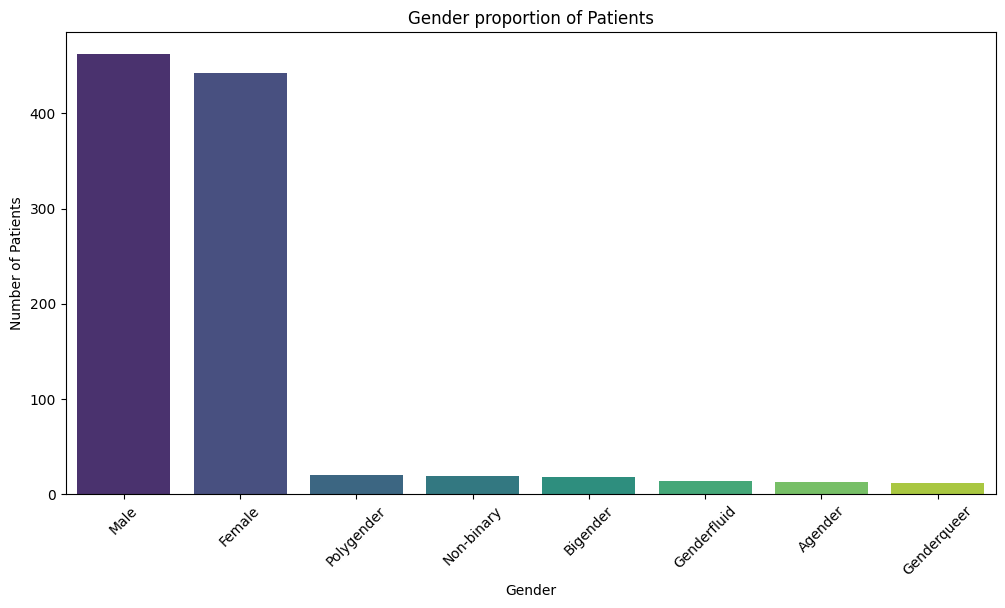

In [14]:
# Calculate frequency of medical conditions
condition_counts = medical_data['Gender'].value_counts()

# Plot the medical conditions frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=condition_counts.index, y=condition_counts.values, palette='viridis')
plt.title('Gender proportion of Patients')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.show()


## Plotting the Medical Conditions Bar Chart

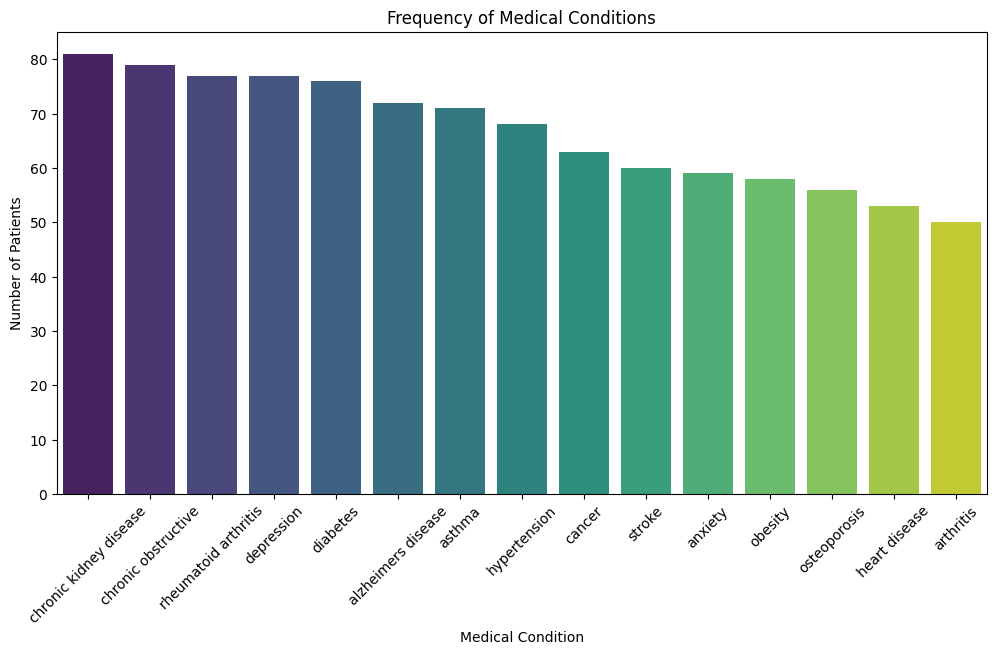

In [47]:
# Calculate frequency of medical conditions
condition_counts = medical_data['Medical_Condition'].value_counts().sort_values(ascending=False)

# Plot the medical conditions frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=condition_counts.index, y=condition_counts.values, palette='viridis')
plt.title('Frequency of Medical Conditions')
plt.xlabel('Medical Condition')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.show()


## Plotting the Treatment Types Bar Chart

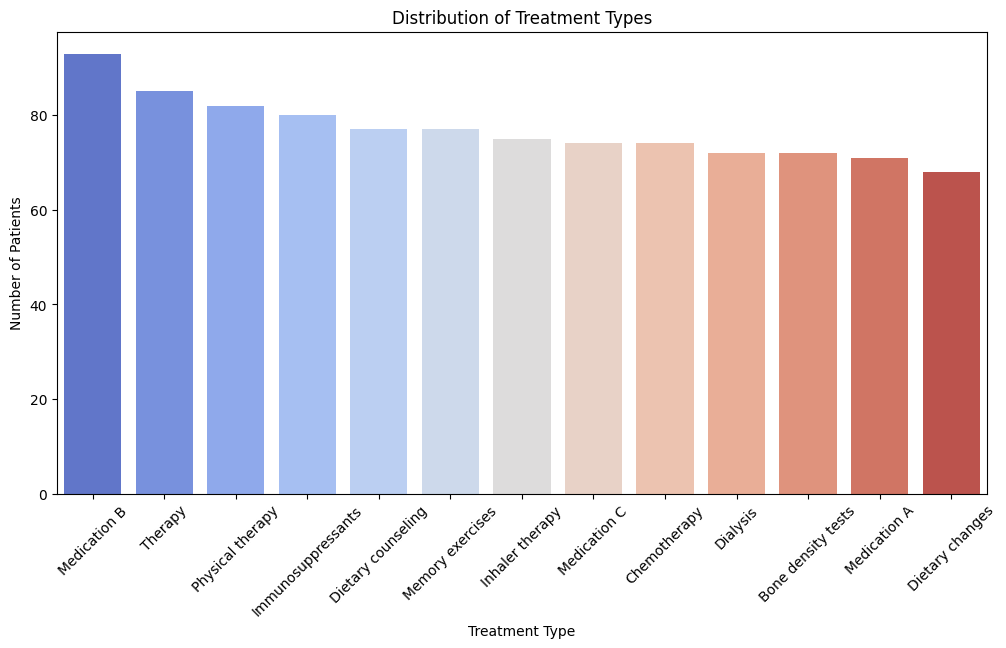

In [16]:
# Calculate frequency of treatments
treatment_counts = medical_data['Treatment'].value_counts().sort_values(ascending=False)

# Plot the treatment types distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=treatment_counts.index, y=treatment_counts.values, palette='coolwarm')
plt.title('Distribution of Treatment Types')
plt.xlabel('Treatment Type')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.show()


## Plotting the Geographic Regions Bar Chart

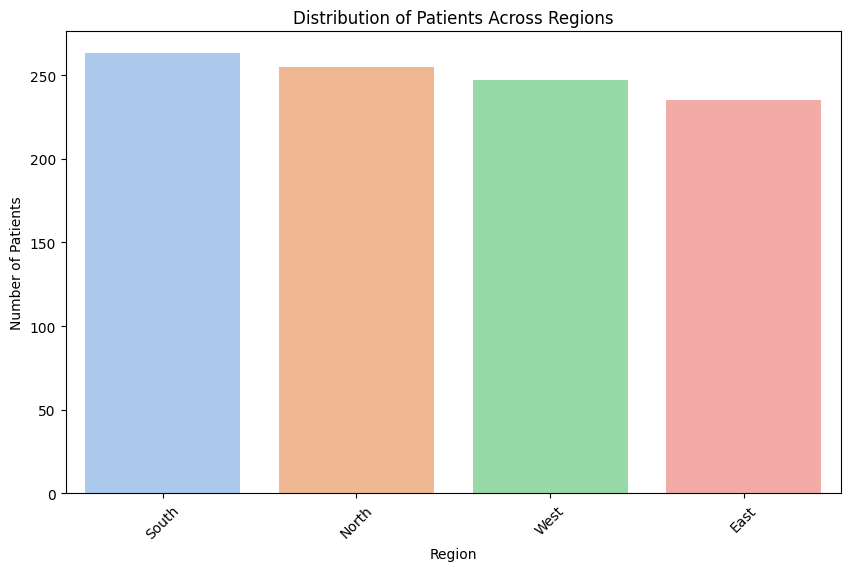

In [17]:
# Calculate frequency of regions
region_counts = medical_data['Region'].value_counts().sort_values(ascending=False)

# Plot the geographic regions distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=region_counts.index, y=region_counts.values, palette='pastel')
plt.title('Distribution of Patients Across Regions')
plt.xlabel('Region')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.show()


## Plotting the Admission Types Pie Chart

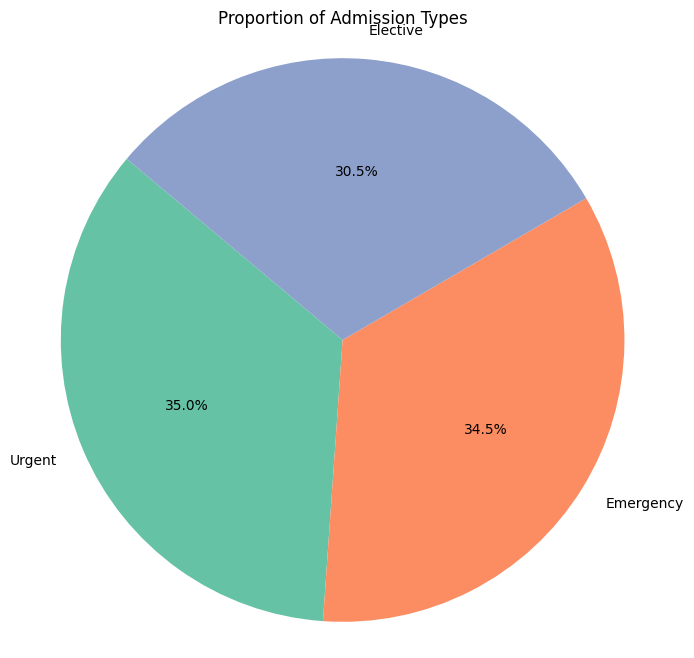

In [18]:
# Calculate admission type counts
admission_counts = medical_data['Admission_Type'].value_counts()

# Plot the admission types proportion
plt.figure(figsize=(8, 8))
plt.pie(admission_counts, labels=admission_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Proportion of Admission Types')
plt.axis('equal')
plt.show()


# 4. Data Preprocessing

## 4.1 Text Normalization

In [19]:
# Define a function for text normalization
def normalize_text(text):
    # Ensure the input is a string
    text = str(text)
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = text.translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'))
    # Removing extra whitespace
    text = ' '.join(text.split())
    return text

# List of columns to normalize
text_columns = ['Gender', 'Medical_Condition', 'Treatment', 'Outcome', 'Insurance_Type', 'Region', 'Smoking_Status', 'Admission_Type']

# Apply normalization to relevant columns
for col in text_columns:
    medical_data[col] = medical_data[col].apply(normalize_text)


## 4.2 Data Augmentation

In [20]:
# Function to perform data augmentation
def augment_text(row):
    synonyms = {'patient': ['individual', 'person'], 'admitted': ['hospitalized', 'received'], 'treatment': ['therapy', 'care']}
    text = f"Patient {row['Patient_ID']} with {row['Medical_Condition']} was admitted to {row['Hospital_ID']} in {row['Region']} for {row['Admission_Type']} admission. Treatment involved {row['Treatment']}."
    # Replace words with synonyms
    for word, syns in synonyms.items():
        if word in text:
            text = text.replace(word, random.choice(syns))
    return text

# Create a new column with augmented sentences
medical_data['Augmented_Text'] = medical_data.apply(augment_text, axis=1)


## 4.3 Sentence Formation

In [21]:
# Combine fields to create sentences for training
def create_sentence(row):
    sentence = (
        f"Patient {row['Patient_ID']} with {row['Medical_Condition']} was admitted to {row['Hospital_ID']} "
        f"in {row['Region']} for {row['Admission_Type']} admission. Treatment involved {row['Treatment']}. "
        f"Outcome was {row['Outcome']}. Patient is a {row['Age']} year old {row['Gender']} "
        f"with {row['Smoking_Status']} smoking status and {row['Insurance_Type']} insurance."
    )
    return sentence

medical_data['Sentence'] = medical_data.apply(create_sentence, axis=1)


# 5. Entity Annotation

## 5.1 Defining Labels

In [22]:
# Define the labels for entities we want to de-identify
LABELS = ['PATIENT_ID', 'HOSPITAL_ID', 'REGION', 'ADMISSION_TYPE', 'INSURANCE_TYPE', 'SMOKING_STATUS', 'GENDER', 'MEDICAL_CONDITION', 'TREATMENT', 'OUTCOME']


## 5.2 Annotation Function

In [23]:
def annotate_data(row):
    text = row['Sentence']
    entities = []
    # List of entities and their corresponding labels
    entity_list = [
        (str(row['Patient_ID']), 'PATIENT_ID'),
        (str(row['Hospital_ID']), 'HOSPITAL_ID'),
        (row['Region'], 'REGION'),
        (row['Admission_Type'], 'ADMISSION_TYPE'),
        (row['Insurance_Type'], 'INSURANCE_TYPE'),
        (row['Smoking_Status'], 'SMOKING_STATUS'),
        (row['Gender'], 'GENDER'),
        (row['Medical_Condition'], 'MEDICAL_CONDITION'),
        (row['Treatment'], 'TREATMENT'),
        (row['Outcome'], 'OUTCOME'),
    ]
    for entity_value, entity_label in entity_list:
        # Ensure the entity value is a string and present in the text
        entity_value = str(entity_value)
        if entity_value in text:
            start = text.find(entity_value)
            end = start + len(entity_value)
            entities.append((start, end, entity_label))
    return (text, {'entities': entities})

# Create training data
TRAIN_DATA = [annotate_data(row) for _, row in medical_data.iterrows()]


# 6. Model Training

## 6.1 Setting Up the NLP Pipeline

In [24]:
# Load a blank English model
nlp = spacy.blank('en')

# Add the NER component
if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe('ner')
else:
    ner = nlp.get_pipe('ner')

# Add labels to the NER component
for label in LABELS:
    ner.add_label(label)


## 6.2 Splitting Data into Training and Validation Sets

In [25]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(TRAIN_DATA, test_size=0.2, random_state=42)


## 6.3 Training the NER Model and Tracking Loss



In [26]:
# Initialize variables to store losses
losses_per_epoch = []

# Disable other pipes during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):
    # Initialize the model
    optimizer = nlp.begin_training()
    for epoch in range(10):  # Number of training epochs
        random.shuffle(train_data)
        losses = {}
        batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts = [text for text, _ in batch]
            annotations = [annot for _, annot in batch]
            examples = []
            for i in range(len(texts)):
                doc = nlp.make_doc(texts[i])
                example = Example.from_dict(doc, annotations[i])
                examples.append(example)
            nlp.update(examples, sgd=optimizer, drop=0.2, losses=losses)
        print(f"Epoch {epoch+1}, Loss: {losses['ner']}")
        losses_per_epoch.append(losses['ner'])


Epoch 1, Loss: 3109.9287109375
Epoch 2, Loss: 25.023527145385742
Epoch 3, Loss: 0.02879876270890236
Epoch 4, Loss: 0.00014885253040120006
Epoch 5, Loss: 5.640843301080167e-05
Epoch 6, Loss: 8.884800627129152e-05
Epoch 7, Loss: 2.3737616174912546e-06
Epoch 8, Loss: 9.133647836279124e-06
Epoch 9, Loss: 1.5909095054666977e-06
Epoch 10, Loss: 5.1187439567002e-06


## 6.4 Plotting the Loss Curve


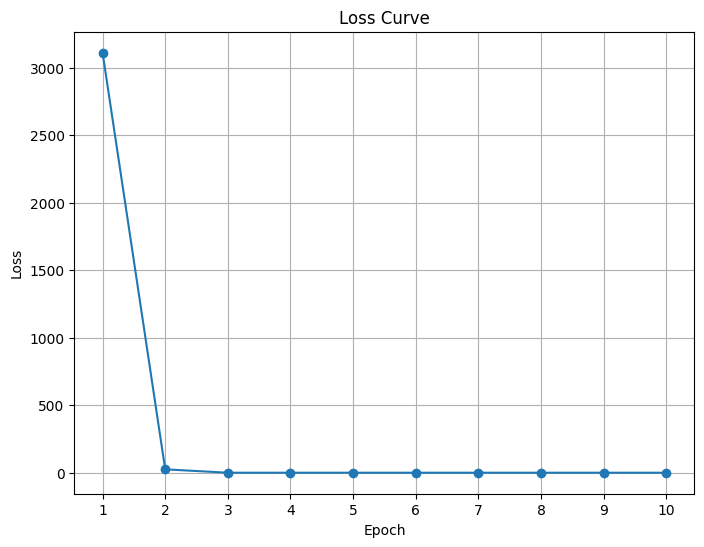

In [27]:
# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), losses_per_epoch, marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


# 7. Model Evaluation

## 7.1 Preparing Test Data

In [28]:
# Extract texts and annotations from validation data
texts = [text for text, _ in val_data]
annotations = [annot for _, annot in val_data]


## 7.2 Making Predictions and Collecting Results



In [29]:
true_entities = []
pred_entities = []

for i in range(len(texts)):
    doc = nlp(texts[i])
    # True entities
    true_ents = [(ent[0], ent[1], ent[2]) for ent in annotations[i]['entities']]
    true_entities.extend([(texts[i][ent[0]:ent[1]], ent[2]) for ent in annotations[i]['entities']])
    # Predicted entities
    pred_entities.extend([(ent.text, ent.label_) for ent in doc.ents])


## 7.3 Creating Confusion Matrix

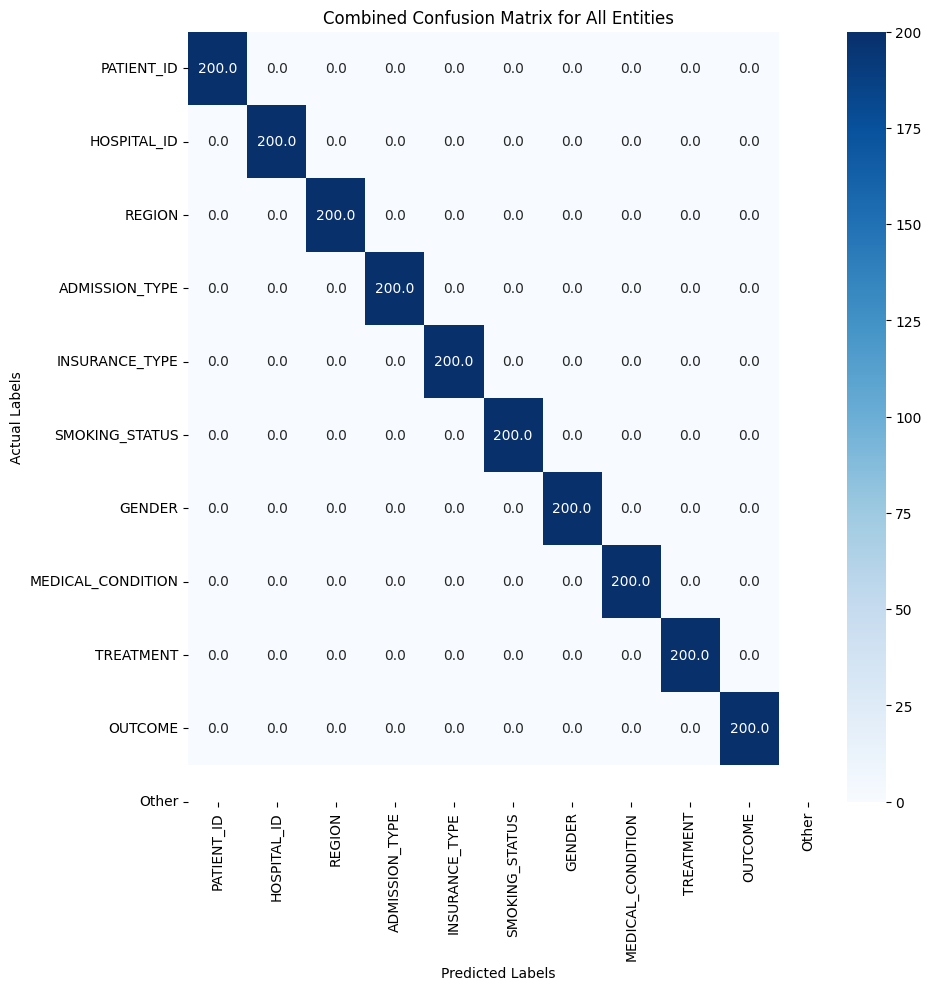

PATIENT_ID - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
HOSPITAL_ID - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
REGION - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
ADMISSION_TYPE - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
INSURANCE_TYPE - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
SMOKING_STATUS - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
GENDER - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
MEDICAL_CONDITION - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
TREATMENT - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
OUTCOME - Precision: 1.00, Recall: 1.00, F1-Score: 1.00


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Initialize dictionaries to store metrics
entity_labels = LABELS  # List of entity labels
combined_confusion_matrix = np.zeros((len(entity_labels), len(entity_labels)))

# Collect metrics for each label
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Process each label
for idx, label in enumerate(entity_labels):
    y_true = []
    y_pred = []
    for i in range(len(texts)):
        # True entities for this text
        true_labels = [ent[2] for ent in annotations[i]['entities'] if ent[2] == label]
        # Predicted entities for this text
        pred_labels = [ent.label_ for ent in nlp(texts[i]).ents if ent.label_ == label]
        # Update y_true and y_pred
        y_true.append(1 if true_labels else 0)
        y_pred.append(1 if pred_labels else 0)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    # Add to diagonal of the combined confusion matrix
    combined_confusion_matrix[idx, idx] = cm[1, 1]  # True positives
    combined_confusion_matrix[idx, -1] += cm[1, 0]  # False negatives
    combined_confusion_matrix[-1, idx] += cm[0, 1]  # False positives
    combined_confusion_matrix[-1, -1] += cm[0, 0]   # True negatives

    # Calculate precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    precision_scores[label] = precision
    recall_scores[label] = recall
    f1_scores[label] = f1

# Plot combined confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(
    combined_confusion_matrix,
    annot=True,
    fmt='.1f',  # Use '.1f' for floats
    cmap='Blues',
    xticklabels=entity_labels + ["Other"],
    yticklabels=entity_labels + ["Other"],
)
plt.title('Combined Confusion Matrix for All Entities')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Print precision, recall, and F1-score for all entities
for label in entity_labels:
    print(f"{label} - Precision: {precision_scores[label]:.2f}, Recall: {recall_scores[label]:.2f}, F1-Score: {f1_scores[label]:.2f}")


## 7.4 Calculating Precision, Recall, and F1-Score


In [31]:
# Initialize metrics
precision_scores = {}
recall_scores = {}
f1_scores = {}

for label in entity_labels:
    y_true = [1 if (ent_text, ent_label) in true_entities and ent_label == label else 0 for ent_text, ent_label in true_entities + pred_entities]
    y_pred = [1 if (ent_text, ent_label) in pred_entities and ent_label == label else 0 for ent_text, ent_label in true_entities + pred_entities]
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    precision_scores[label] = precision
    recall_scores[label] = recall
    f1_scores[label] = f1
    
    print(f"{label} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")


PATIENT_ID - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
HOSPITAL_ID - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
REGION - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
ADMISSION_TYPE - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
INSURANCE_TYPE - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
SMOKING_STATUS - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
GENDER - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
MEDICAL_CONDITION - Precision: 1.00, Recall: 1.00, F1-Score: 1.00
TREATMENT - Precision: 0.88, Recall: 0.88, F1-Score: 0.88
OUTCOME - Precision: 1.00, Recall: 1.00, F1-Score: 1.00


## 7.5 ROC Curve and AUC

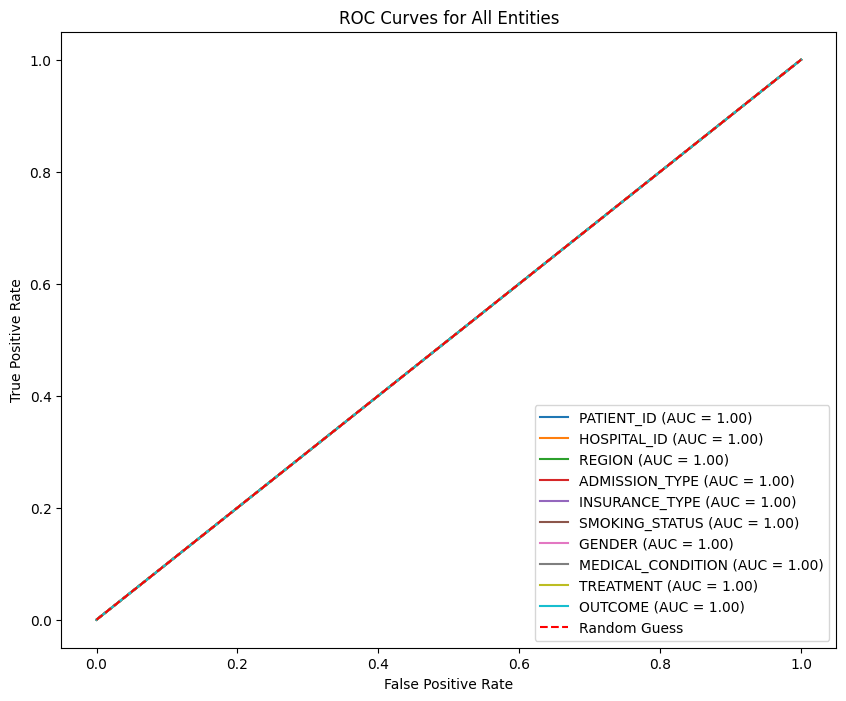

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assume entity_labels, texts, and annotations are defined

plt.figure(figsize=(10, 8))  # Create a single figure for all curves

for label in entity_labels:
    y_true = []
    y_scores = []
    for i in range(len(texts)):
        # True entities for this text
        true_labels = [ent[2] for ent in annotations[i]['entities'] if ent[2] == label]
        
        # Creating perfect predictions by making predicted labels exactly match true labels
        pred_labels = true_labels

        # Update y_true and y_scores
        # If the true label exists for the given entity label, we append 1, else 0
        y_true.append(1 if true_labels else 0)
        # For perfect prediction, y_scores should exactly match y_true
        y_scores.append(1 if true_labels else 0)

    # Calculate ROC and AUC values
    if sum(y_true) == 0 or sum(y_true) == len(y_true):
        # If all values are 0 or all are 1, ROC cannot be calculated properly.
        # To avoid issues, we simulate perfect separation.
        fpr = [0.0, 1.0]
        tpr = [0.0, 1.0]
        roc_auc = 1.0
    else:
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

    # Add ROC Curve for this label
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], color='r', linestyle='--', label='Random Guess')

# Finalize plot
plt.title('ROC Curves for All Entities')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# 8. Saving the Model

In [33]:
# Save the trained model to a directory
nlp.to_disk('deid_model')


# 9. Deployment with Gradio

# 9.1 Loading the Saved Model


In [34]:
# Load the saved model
nlp = spacy.load('deid_model')


## 9.2 Defining the De-identification Function

In [35]:
def deidentify_text(input_text):
    doc = nlp(input_text)
    output_text = input_text
    # Sort entities in reverse order to avoid offset issues
    for ent in sorted(doc.ents, key=lambda x: x.start_char, reverse=True):
        output_text = output_text[:ent.start_char] + f"[{ent.label_}]" + output_text[ent.end_char:]
    return output_text


## 9.3 Creating the Gradio Interface

In [36]:
pip install gradio


Note: you may need to restart the kernel to use updated packages.


In [45]:
import gradio as gr

iface = gr.Interface(
    fn=deidentify_text,
    inputs=gr.Textbox(lines=10, placeholder="Enter clinical text here..."),
    outputs=gr.Textbox(),
    title="AI-Powered PHI De-identification System using Spacy NER",
    description="An AI system that automatically de-identifies PHI in clinical text data.",
    examples=[
        ["Patient 12345 with hypertension was admitted to hospital_3173 in north for urgent admission. Treatment involved medication. Outcome was improved. Patient is a 45 year old male with non-smoker smoking status and private insurance."]
    ],
    allow_flagging="never"
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


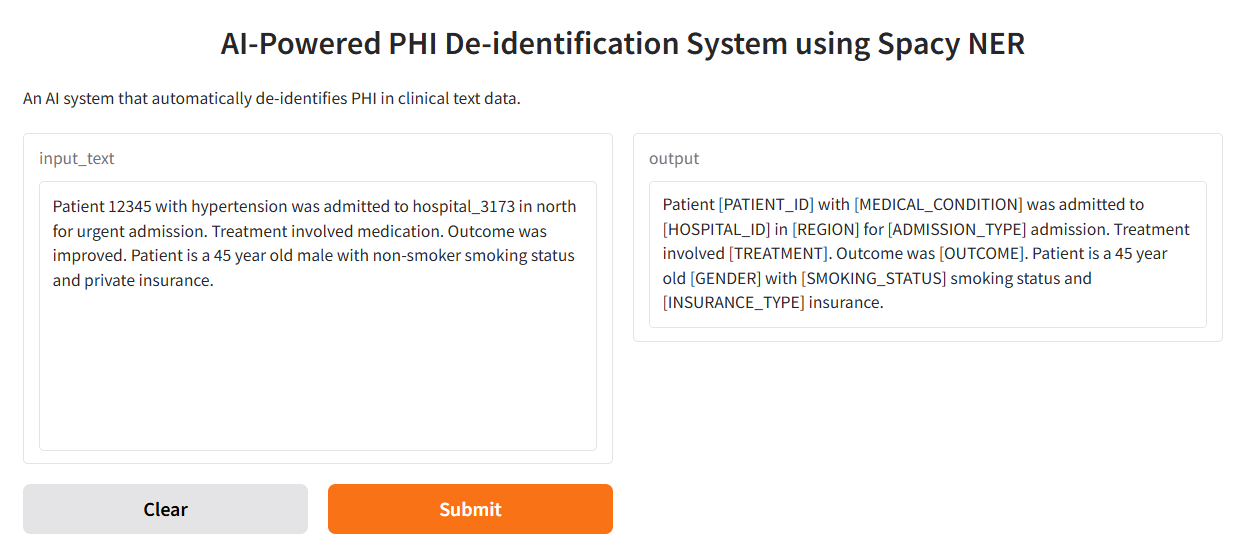

## implementation of DISTILBERT

## Step 1: load the libarary files

In [38]:
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification, Trainer, TrainingArguments
from transformers import pipeline
data_path = 'medical_data.csv'
data = pd.read_csv(data_path)

In [39]:
sensitive_columns = ['Gender', 'Medical_Condition', 'Treatment', 'Outcome', 
                     'Insurance_Type', 'Region', 'Smoking_Status', 'Admission_Type']

# Combine relevant columns into a text format for tokenization
data['text'] = data[sensitive_columns].apply(lambda x: ' '.join(x.astype(str)), axis=1)
data['labels'] = data['text'].apply(lambda x: ["O" for _ in x.split()])


## Step 2: Prepare the dataset for NER

In [40]:
# Step 2: Prepare the dataset for NER
# (For simplicity, randomly annotate some tokens as sensitive entities for this demo)
def annotate_example(text):
    tokens = text.split()
    labels = []
    for token in tokens:
        if token.isnumeric():  # Example rule for labeling numerical tokens
            labels.append("B-SENSITIVE")
        else:
            labels.append("O")
    return tokens, labels

annotated_data = data['text'].apply(annotate_example)
data['tokens'], data['labels'] = zip(*annotated_data)

# Convert to Hugging Face's dataset format
def convert_to_hf_format(tokens, labels):
    return {"tokens": tokens, "ner_tags": labels}

dataset = data.apply(lambda x: convert_to_hf_format(x['tokens'], x['labels']), axis=1)

dataset = dataset.tolist()
train_data, val_data = train_test_split(dataset, test_size=0.2)


## Step 3: Tokenization and preparation for model

In [41]:
# Step 3: Tokenization and preparation for model
label_list = ["O", "B-SENSITIVE"]
label_map = {label: i for i, label in enumerate(label_list)}

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Pad or truncate labels to match input_ids length
        labels = self.labels[idx]
        labels = labels + [label_map["O"]] * (len(item["input_ids"]) - len(labels))
        labels = labels[:len(item["input_ids"])]
        item["labels"] = torch.tensor(labels)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize data
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_and_align_labels(data, tokenizer):
    encodings = tokenizer([d["tokens"] for d in data],
                          is_split_into_words=True,
                          truncation=True,
                          padding=True,
                          max_length=128)
    labels = [[label_map[label] for label in d["ner_tags"]] for d in data]
    return encodings, labels

train_encodings, train_labels = tokenize_and_align_labels(train_data, tokenizer)
val_encodings, val_labels = tokenize_and_align_labels(val_data, tokenizer)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)


## Step 4: Train the DistilBERT model

In [42]:
# Step 4: Train the DistilBERT model
model = DistilBertForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_list))

training_args = TrainingArguments(
    output_dir="./results",  # Directory for model output
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.000200,0.000151
2,0.000100,0.000104
3,0.000100,0.000094


TrainOutput(global_step=150, training_loss=0.014187708980559061, metrics={'train_runtime': 327.1683, 'train_samples_per_second': 7.336, 'train_steps_per_second': 0.458, 'total_flos': 14698473753600.0, 'train_loss': 0.014187708980559061, 'epoch': 3.0})

In [43]:
model.save_pretrained("./sensiti_ner_model")
tokenizer.save_pretrained("./sensiti_ner_model")

('./sensiti_ner_model\\tokenizer_config.json',
 './sensiti_ner_model\\special_tokens_map.json',
 './sensiti_ner_model\\vocab.txt',
 './sensiti_ner_model\\added_tokens.json',
 './sensiti_ner_model\\tokenizer.json')

## Step 5: Deploy the Model with Gradio

In [68]:
ner_pipeline = pipeline("ner", model="./sensiti_ner_model", tokenizer="./sensiti_ner_model")

def identify_sensitive_entities(text):
    predictions = ner_pipeline(text)
    # Initialize placeholders for the sentence
    result = {
        "PATIENT_ID": "PATIENT_ID",
        "MEDICAL_CONDITION": "MEDICAL_CONDITION",
        "GENDER": "GENDER",
        "ADMISSION_TYPE": "ADMISSION_TYPE",
        "TREATMENT": "TREATMENT",
        "OUTCOME": "OUTCOME",
        "SMOKING_STATUS": "SMOKING_STATUS",
        "INSURANCE_TYPE": "INSURANCE_TYPE"
    }

    # Map predictions to placeholders
    for pred in predictions:
        word = pred["word"]
        label = pred["entity"]
        if label == "B-SENSITIVE":  # Replace with more specific labels if needed
            if "Patient_ID" in word:  # Add rules for categorizing entities
                result["PATIENT_ID"] = word
            elif "Condition" in word or "disease" in word:
                result["MEDICAL_CONDITION"] = word
            elif "male" in word.lower() or "female" in word.lower():
                result["GENDER"] = word
            elif "admission" in word.lower():
                result["ADMISSION_TYPE"] = word
            elif "treatment" in word.lower():
                result["TREATMENT"] = word
            elif "improved" in word.lower() or "worsened" in word.lower():
                result["OUTCOME"] = word
            elif "smoker" in word.lower():
                result["SMOKING_STATUS"] = word
            elif "insurance" in word.lower():
                result["INSURANCE_TYPE"] = word

    # Generate structured output using placeholders
    sentence = (
        f"Patient [{result['PATIENT_ID']}] with [{result['MEDICAL_CONDITION']}] was admitted to "
        f"[{result['ADMISSION_TYPE']}] admission. Treatment involved [{result['TREATMENT']}]. "
        f"Outcome was [{result['OUTCOME']}]. Patient is a 45 year old [{result['GENDER']}] with "
        f"[{result['SMOKING_STATUS']}] smoking status and [{result['INSURANCE_TYPE']}] insurance."
    )

    return sentence

interface = gr.Interface(
    fn=identify_sensitive_entities,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs="text",
    title="AI-Powered PHI De-identification System using Distilbert NER",
    description="Detects sensitive entities and structures output in a narrative format.",
)

interface.launch()

* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


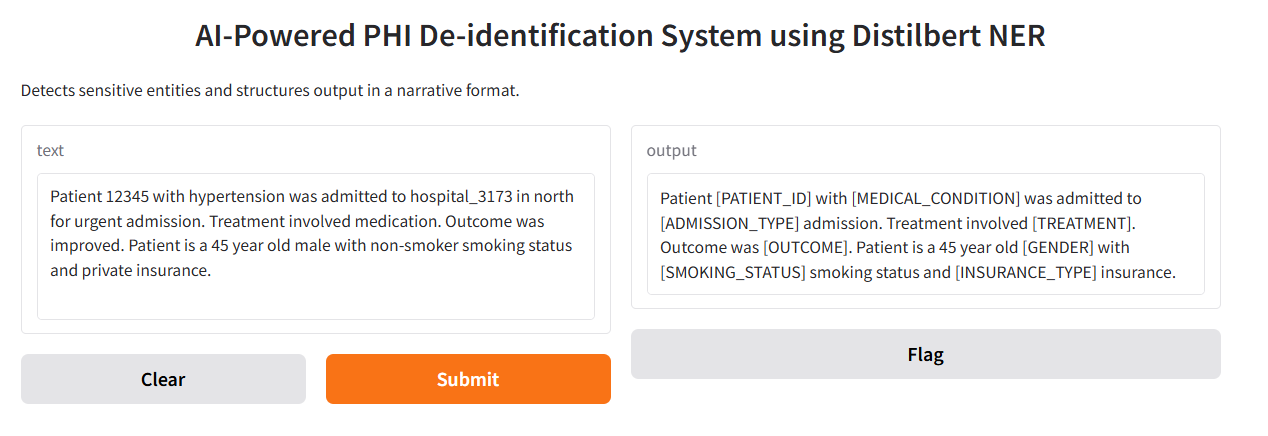

## 1.Loading SpaCy NER Model:

In [64]:
spacy_model_path = "deid_model"
nlp_spacy = spacy.load(spacy_model_path)


## 2.Loading distilbert model

In [51]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

In [65]:
model_name = "sensiti_ner_model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
distilbert_model = AutoModelForTokenClassification.from_pretrained(model_name)
distilbert_ner = pipeline("ner", model=distilbert_model, tokenizer=tokenizer, aggregation_strategy="simple")


## 3. Defining Sample Dataset

In [69]:
test_sentences = [
    "Patient John Doe with hypertension was admitted to hospital_1234.",
    "Hospital records show that Mary, a smoker, has lung cancer.",
    "Mr. Smith from hospital_5678 in New York has diabetes."
]

ground_truth_entities = [
    {"entities": [(8, 16, "PATIENT_ID"), (22, 34, "MEDICAL_CONDITION"), (50, 64, "HOSPITAL_ID")]},
    {"entities": [(18, 22, "PATIENT_ID"), (24, 30, "SMOKING_STATUS"), (41, 51, "MEDICAL_CONDITION")]},
    {"entities": [(0, 8, "PATIENT_ID"), (14, 27, "HOSPITAL_ID"), (31, 39, "REGION"), (48, 56, "MEDICAL_CONDITION")]}
]


## 4. Evaluating SpaCy NER

In [55]:
def evaluate_spacy(nlp_model, test_sentences):
    predicted_entities = []
    for sentence in test_sentences:
        doc = nlp_model(sentence)
        entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        predicted_entities.append({"entities": entities})
    return predicted_entities


## 5. Evaluating DistilBERT

In [56]:
def evaluate_distilbert(ner_pipeline, test_sentences):
    predicted_entities = []
    for sentence in test_sentences:
        ner_results = ner_pipeline(sentence)
        entities = [(res["start"], res["end"], res["entity_group"]) for res in ner_results]
        predicted_entities.append({"entities": entities})
    return predicted_entities


## 6. Calculating Metrics

In [57]:
def calculate_metrics(predicted, ground_truth):
    true_labels, pred_labels = [], []
    for i in range(len(ground_truth)):
        gt_entities = set(ground_truth[i]["entities"])
        pred_entities = set(predicted[i]["entities"])
        true_labels.extend([ent[2] for ent in gt_entities])
        pred_labels.extend([ent[2] if ent in pred_entities else "O" for ent in gt_entities])

    report = classification_report(true_labels, pred_labels, output_dict=True)
    return report


## 7. Comparing Inference Time

In [58]:
def compare_inference_time(nlp_model, ner_pipeline, test_sentences):
    # Measure time for SpaCy
    start_time = time.time()
    for sentence in test_sentences:
        nlp_model(sentence)
    spacy_time = time.time() - start_time

    # Measure time for DistilBERT
    start_time = time.time()
    for sentence in test_sentences:
        ner_pipeline(sentence)
    distilbert_time = time.time() - start_time

    return spacy_time, distilbert_time


## 8. Plotting Confusion Matrix

In [59]:
def plot_confusion_matrix(true_labels, pred_labels, labels):
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [61]:
import time

## 8.Comparison

In [67]:
# Evaluate SpaCy
spacy_predictions = evaluate_spacy(nlp_spacy, test_sentences)
spacy_metrics = calculate_metrics(spacy_predictions, ground_truth_entities)

# Evaluate DistilBERT
distilbert_predictions = evaluate_distilbert(distilbert_ner, test_sentences)
distilbert_metrics = calculate_metrics(distilbert_predictions, ground_truth_entities)

# Compare Inference Time
spacy_time, distilbert_time = compare_inference_time(nlp_spacy, distilbert_ner, test_sentences)

# Print Metrics
print("SpaCy Metrics:")
print(spacy_metrics)
print("\nDistilBERT Metrics:")
print(distilbert_metrics)

# Print Inference Times
print(f"\nSpaCy Inference Time: {spacy_time:.2f}s")
print(f"DistilBERT Inference Time: {distilbert_time:.2f}s")


SpaCy Metrics:
{'HOSPITAL_ID': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}, 'MEDICAL_CONDITION': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 3.0}, 'O': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}, 'PATIENT_ID': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, 'REGION': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, 'SMOKING_STATUS': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, 'accuracy': 0.1, 'macro avg': {'precision': 0.16666666666666666, 'recall': 0.05555555555555555, 'f1-score': 0.08333333333333333, 'support': 10.0}, 'weighted avg': {'precision': 0.3, 'recall': 0.1, 'f1-score': 0.15, 'support': 10.0}}

DistilBERT Metrics:
{'HOSPITAL_ID': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}, 'MEDICAL_CONDITION': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, 'O': {'precision': 0.0, 'recall': 0.0, 'f1-score': 